## Prepared for the textbook:
-------------------------------------------------------------------
## Data Analysis for Business, Economics, and Policy
#### by Gabor BEKES and  Gabor KEZDI 
----------------------------------
#### Cambridge University Press 2021
-----------------------------------------------------------------------------------------------
#### License: Free to share, modify and use for educational purposes. Not to be used for business purposes.


### Import libraries and set folders

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"
# location folders
data_in = dirname + "da_data_repo/hotels-vienna/clean/"
data_out = dirname + "da_case_studies/ch07-hotels-simple-reg/"
output = dirname + "da_case_studies/ch07-hotels-simple-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)
# Import the prewritten helper functions
from py_helper_functions import *

In [3]:
# load vienna
hotels = pd.read_csv(data_in+"hotels-vienna.csv")

In [4]:
####SAMPLE SELECTION
# Apply filters:  3-4 stars, Vienna actual, without  extreme value
hotels = (
    hotels.query('accommodation_type=="Hotel"')
    .query('city_actual=="Vienna"')
    .query("stars>=3 & stars<=4")
    .query("stars.notna()")
    .query("price<=600")
)

In [5]:
# save a copy of the work file
hotels.to_csv(data_out+"hotels_work.csv",index=False)

### Summary statistics on price and distance

In [6]:
#Price
hotels[['price']].describe(percentiles=[0.50,0.95])

,price
count,207.000000
mean,109.975845
std,42.221381
min,50.000000
50%,100.000000
95%,183.400000
max,383.000000


In [7]:
# Distance
hotels[['distance']].describe(percentiles=[0.50,0.95])

,distance
count,207.000000
mean,1.529952
std,1.161507
min,0.000000
50%,1.300000
95%,3.900000
max,6.600000


In [8]:
### REGRESSION 1: CLOSE VS FAR REGRESSION WITH BINARY DISTANCE

In [9]:
#hotels=hotels.assign(dist2=lambda x: x.distance>=2)
hotels["dist2"]=hotels.distance.apply(lambda x: int(x>=2))

In [10]:
dist2=hotels.groupby("dist2").aggregate(Eprice_cat2=("price",np.mean))

In [11]:
hotels=hotels.merge(dist2,left_on="dist2",right_on=dist2.index)

In [12]:
hotels.dist2=hotels.dist2.replace(0,"Close")
hotels.dist2=hotels.dist2.replace(1,"Far")

In [13]:
hotels[["dist2","distance","price"]].groupby("dist2").aggregate("describe")

distance                                               price  \
         count      mean       std  min  25%  50%  75%  max  count   
dist2                                                                
Close    157.0  0.994904  0.539325  0.0  0.5  0.9  1.5  1.9  157.0   
Far       50.0  3.210000  0.973789  2.0  2.4  3.1  3.7  6.6   50.0   

                                                                
             mean        std   min    25%    50%    75%    max  
dist2                                                           
Close  116.426752  43.095928  54.0  85.00  109.0  135.0  383.0  
Far     89.720000  32.085371  50.0  74.25   81.5   96.5  208.0

# Figure 7.1a
# PLOT MEAN VALUES BY CLOSE VS FAR

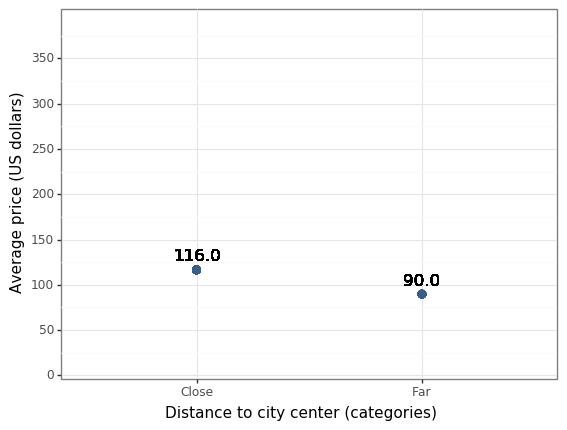

<ggplot: (8787306094596)>

In [14]:
ggplot(hotels) + geom_point(
    aes(x="dist2", y="Eprice_cat2"),
    size=2.5,
    color=color[0],
    fill=color[0],
    alpha=0.4
) + geom_text(
    aes(x="dist2", y="[x+15 for x in Eprice_cat2]", label=np.round(hotels.Eprice_cat2)),
    color="black",
    size=12,
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + expand_limits(
    y=0.01
) + scale_x_discrete() + labs(
    x="Distance to city center (categories)", y="Average price (US dollars)"
) + theme_bw()

In [15]:
hotels["dist4"] = hotels.distance.apply(
    lambda x: 0.5 + 1 * int(x >= 1) + 1 * int(x > 2) + 2.5 * int(x >= 3)
)

In [16]:
dist4 = hotels.groupby("dist4").aggregate(Eprice_cat4=("price", np.mean))

In [17]:
hotels = hotels.merge(dist4, left_on="dist4", right_on=dist4.index)

In [18]:
hotels[["dist4", "distance", "price"]].groupby("dist4").aggregate("describe")

distance                                                  price  \
         count      mean       std  min    25%  50%    75%  max count   
dist4                                                                   
0.5       81.0  0.554321  0.282865  0.0  0.300  0.6  0.800  0.9  81.0   
1.5       80.0  1.491250  0.309836  1.0  1.200  1.5  1.700  2.0  80.0   
2.5       18.0  2.433333  0.299018  2.1  2.100  2.4  2.675  2.9  18.0   
5.0       28.0  3.882143  0.759656  3.0  3.475  3.7  4.100  6.6  28.0   

                                                                  
             mean        std   min     25%    50%     75%    max  
dist4                                                             
0.5    132.913580  38.540627  68.0  110.00  128.0  152.00  242.0  
1.5     97.625000  40.598489  54.0   79.75   90.0  105.25  383.0  
2.5    102.722222  41.378889  69.0   80.25   83.0  100.75  208.0  
5.0     83.571429  22.596998  50.0   68.75   79.0   91.25  156.0

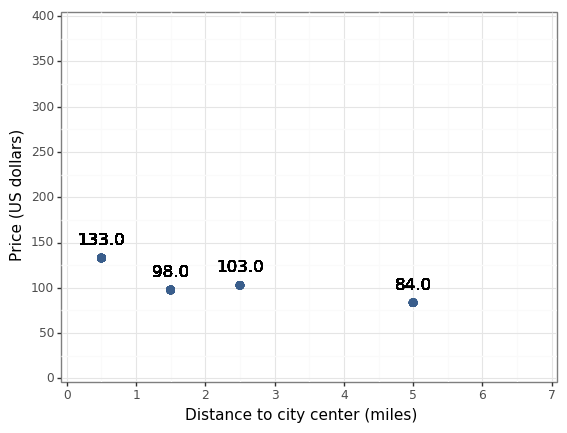

<ggplot: (8787305904162)>

In [19]:
ggplot(data=hotels) + geom_point(
    aes(x="dist4", y="Eprice_cat4"),
    size=2.5,
    color=color[0],
    fill=color[0],
    alpha=0.4,
) + geom_text(
    aes(x="dist4", y="[x+20 for x in Eprice_cat4]", label=np.round(hotels.Eprice_cat4)),
    color="black",
    size=12,
) + expand_limits(
    x=0.01, y=0.01
) + coord_cartesian(
    xlim=[0, 7], ylim=[0, 400]
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50)
) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=[0, 1, 2, 3, 4, 5, 6, 7]
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()

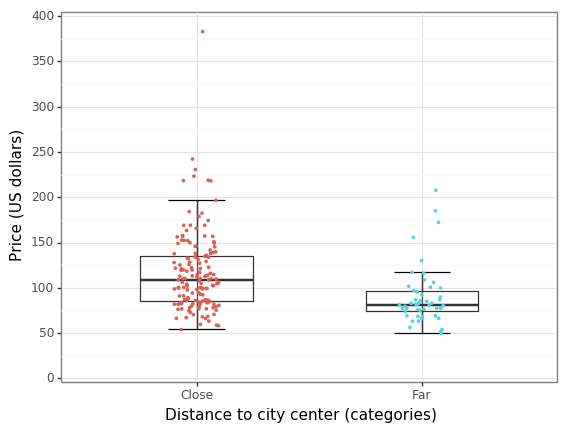

<ggplot: (8787305777204)>

In [20]:
ggplot(hotels, aes(x="dist2", y="price")) + stat_boxplot(
    aes(group="dist2"),
    geom="errorbar",
    width=0.25,
    size=0.5
) + geom_boxplot(
    aes(group="dist2"),
    size=0.5,
    width=0.5,
    alpha=0.3,
    outlier_shape="",
) + geom_jitter(
    aes(color="dist2"), position=position_jitter(0.1), size=0.5, show_legend=False
) + labs(
    x="Distance to city center (categories)", y="Price (US dollars)"
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 401, 50)
) + expand_limits(
    y=0.01
) + theme_bw()

############
# FIGURE 7.2a 7.2b

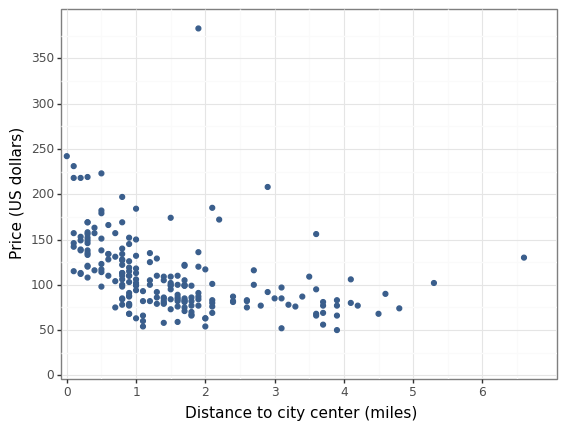

<ggplot: (8787305895458)>


In [21]:
p1 = ggplot(hotels, aes(x="distance", y="price")) + geom_point(color=color[0]) + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1)
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()
print(p1)

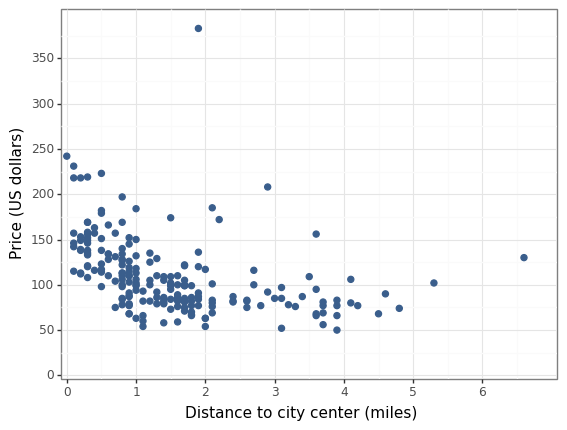

<ggplot: (8787305728591)>

In [22]:
# large sized graphs
ggplot(hotels) + geom_point(
    aes(x="distance", y="price"),
    color=color[0],
    size=2,
    alpha=0.5,
    show_legend=False,
    na_rm=True,
) + expand_limits(x=0.01, y=0.01) + scale_x_continuous(
    expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 7, 1)
) + scale_y_continuous(
    expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50)
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + theme_bw()

In [23]:
# Scatterplot with step function (we use 1km bits for simpplicity using 4 bits for 3-7km)

In [24]:
hotels["dist4_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
)
hotels["xend"] = hotels["dist4_s"] + 1
hotels["yend"] = hotels["Eprice_cat4"]

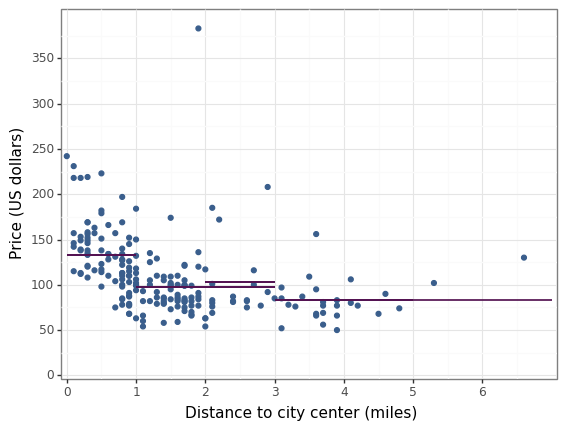

<ggplot: (8787386168230)>


In [25]:
F07_2a = p1 + geom_segment(
    hotels,
    aes("dist4_s", "yend", xend="xend", yend="yend"),
    color=color[2],
    size=0.7,
    na_rm=True,
)
print(F07_2a)

In [26]:
hotels["dist7_new"] = hotels.distance.apply(
    lambda x: 0.5
    + 1 * int(x + 1 >= 1)
    + 1 * int(x + 1 >= 2)
    + 1 * int(x + 1 >= 3)
    + 1 * int(x + 1 >= 4)
    + 1 * int(x + 1 >= 5)
    + 1 * int(x + 1 >= 6)
    + 1 * int(x + 1 >= 7)
)

In [27]:
dist7_new = hotels.groupby("dist7_new").aggregate(Eprice_cat7_new=("price", np.mean))

In [28]:
hotels = hotels.merge(dist7_new, left_on="dist7_new", right_on=dist7_new.index)

In [29]:
hotels[["dist7_new", "distance", "price"]].groupby("dist7_new").aggregate("describe")

distance                                                   price  \
             count      mean       std  min    25%   50%    75%  max count   
dist7_new                                                                    
1.5           81.0  0.554321  0.282865  0.0  0.300  0.60  0.800  0.9  81.0   
2.5           76.0  1.464474  0.294258  1.0  1.200  1.50  1.700  1.9  76.0   
3.5           22.0  2.354545  0.318818  2.0  2.100  2.30  2.600  2.9  22.0   
4.5           20.0  3.525000  0.298901  3.0  3.275  3.60  3.700  3.9  20.0   
5.5            6.0  4.383333  0.292689  4.1  4.125  4.35  4.575  4.8   6.0   
6.5            1.0  5.300000       NaN  5.3  5.300  5.30  5.300  5.3   1.0   
7.5            1.0  6.600000       NaN  6.6  6.600  6.60  6.600  6.6   1.0   

                                                                       
                 mean        std    min     25%    50%     75%    max  
dist7_new                                                              
1.5        132.913580  38.540627   68.0  110.00  128.0  152.00  242.0  
2.5         98.855263  40.893261   54.0   81.75   91.5  105.25  383.0  
3.5         97.545455  40.385909   54.0   76.25   82.5  100.75  208.0  
4.5         80.650000  23.154572   50.0   67.50   77.5   85.50  156.0  
5.5         82.500000  13.619838   68.0   74.75   78.5   87.50  106.0  
6.5        102.000000        NaN  102.0  102.00  102.0  102.00  102.0  
7.5        130.000000        NaN  130.0  130.00  130.0  130.00  130.0

In [30]:
# Scatterplot with step function, starting point is simply at cut-off
hotels["dist7_s"] = hotels.distance.apply(
    lambda x: 1 * int(x >= 1)
    + 1 * int(x >= 2)
    + 1 * int(x >= 3)
    + 1 * int(x >= 4)
    + 1 * int(x >= 5)
    + 1 * int(x >= 6)
    + 1 * int(x >= 7)
)
hotels["xend"] = hotels["dist7_s"] + 1
hotels["yend"] = hotels["Eprice_cat7_new"]

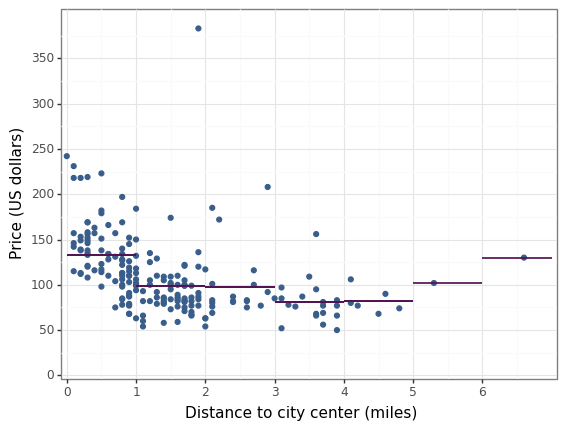

<ggplot: (8787305696371)>


In [31]:
F07_2b = p1 + geom_segment(
    hotels,
    aes(x="dist7_s", y="yend", xend="xend", yend="yend"),
    color=color[2],
    size=0.7,
    na_rm=True,
)
print(F07_2b)

#######################
# Figure 7.3
### LOWESS NONPARAMETRIC REGRESSION

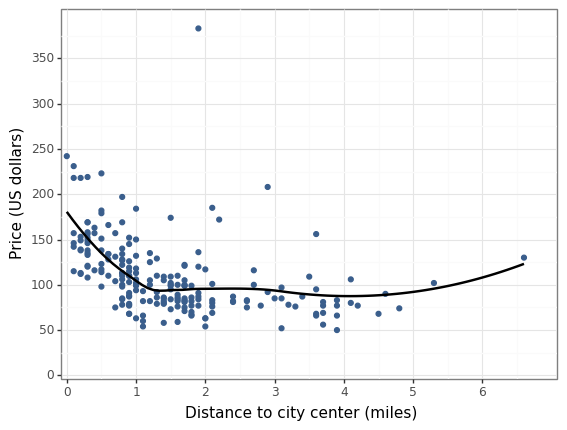

<ggplot: (8787306095562)>


In [32]:
F07_3 = p1 + geom_smooth(method="loess", se=False)
print(F07_3)

In [33]:
### LINEAR REGRESSIONS
regression = smf.ols(formula="price~distance", data=hotels).fit()
regression.summary()
#regression.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Fri, 18 Sep 2020   Prob (F-statistic):           3.39e-09
Time:                        15:54:53   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#######################
# Figure 7.5
### SCATTERPLOT + REGRESSION LINE

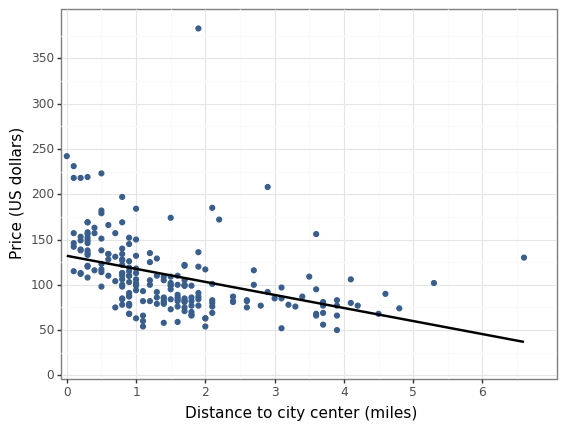

<ggplot: (8787386179094)>


In [34]:
F07_5 = p1 + geom_smooth(method="lm",se=False)
print(F07_5)

### THE LINEAR REGRESSION GOES THROUGH THE AVERAGES
### SCATTERPLOT + REGRESSION LINE + LINES FOR AVERAGES (NOT in BOOK)

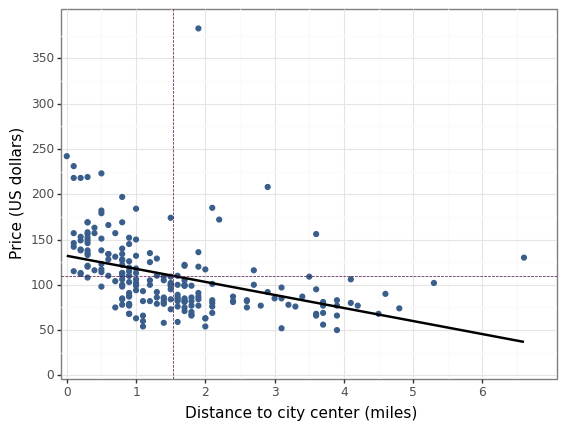

<ggplot: (8787287247415)>


In [35]:
F07_x5 = (
    p1
    + geom_smooth(method="lm",se=False)
    + geom_vline(
        xintercept=hotels["distance"].mean(),
        color=color[2],
        linetype="dashed",
        size=0.3,
    )
    + geom_hline(
        yintercept=hotels["price"].mean(), color=color[2], linetype="dashed", size=0.3
    )
)
print(F07_x5)

### PREDICTED VALUES & RESIDUALS OF LINEAR REGRESSION 

In [36]:
regression = smf.ols(formula="price~distance", data=hotels).fit()

In [37]:
hotels

,country,city_actual,rating_count,center1label,center2label,neighbourhood,price,city,stars,ratingta,...,dist2,Eprice_cat2,dist4,Eprice_cat4,dist4_s,xend,yend,dist7_new,Eprice_cat7_new,dist7_s
0,Austria,Vienna,189.0,City centre,Donauturm,17. Hernals,81,Vienna,4.0,3.5,...,Close,116.426752,1.5,97.625000,1,2,98.855263,2.5,98.855263,1
1,Austria,Vienna,53.0,City centre,Donauturm,Alsergrund,85,Vienna,4.0,3.5,...,Close,116.426752,1.5,97.625000,1,2,98.855263,2.5,98.855263,1
2,Austria,Vienna,55.0,City centre,Donauturm,Alsergrund,83,Vienna,3.0,4.0,...,Close,116.426752,1.5,97.625000,1,2,98.855263,2.5,98.855263,1
3,Austria,Vienna,33.0,City centre,Donauturm,Alsergrund,82,Vienna,4.0,3.5,...,Close,116.426752,1.5,97.625000,1,2,98.855263,2.5,98.855263,1
4,Austria,Vienna,161.0,City centre,Donauturm,Alsergrund,150,Vienna,4.0,4.5,...,Close,116.426752,1.5,97.625000,1,2,98.855263,2.5,98.855263,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Austria,Vienna,171.0,City centre,Donauturm,Vienna,78,Vienna,3.0,4.0,...,Far,89.720000,5.0,83.571429,3,4,80.650000,4.5,80.650000,3
203,Austria,Vienna,34.0,City centre,Donauturm,Vienna,76,Vienna,3.0,4.0,...,Far,89.720000,5.0,83.571429,3,4,80.650000,4.5,80.650000,3
204,Austria,Vienna,168.0,City centre,Donauturm,Wahring,85,Vienna,4.0,3.5,...,Far,89.720000,5.0,83.571429,3,4,80.650000,4.5,80.650000,3
205,Austria,Vienna,28.0,City centre,Donauturm,Vienna,102,Vienna,3.0,4.5,...,Far,89.720000,5.0,83.571429,5,6,102.000000,6.5,102.000000,5


In [38]:
hotels["predprice"] = regression.predict()
hotels["e"] = regression.resid

In [39]:
type(regression)

statsmodels.regression.linear_model.RegressionResultsWrapper

###########
### Figure 7.6, Table 7.1

In [40]:
xa= 2.9
ya= 208
ym= 90.24 
# FIXME
# ym  --should be replaced with predicted value directly

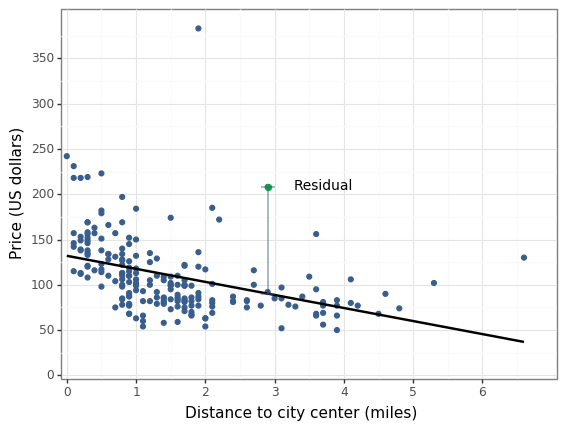

<ggplot: (8787287183053)>


In [41]:
F07_6a = (
    p1
    + geom_smooth(method="lm", se=False)
    + annotate(
        "text",
        x=3.7,
        y=210,
        label="Residual",
        size=10,
    )
    + annotate("pointrange", x=xa, y=ya, ymin=ya, ymax=ya, color=color[1], size=0.5)
    + geom_errorbar(
        hotels.loc[hotels["distance"] == xa],
        aes(x="distance", ymin=ym, ymax=ya),
        width=0.2,
        size=0.2,
        color=color[0],
    )
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 7), breaks=seq(0, 7, by=1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 400, by=50)
    )
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)

print(F07_6a)

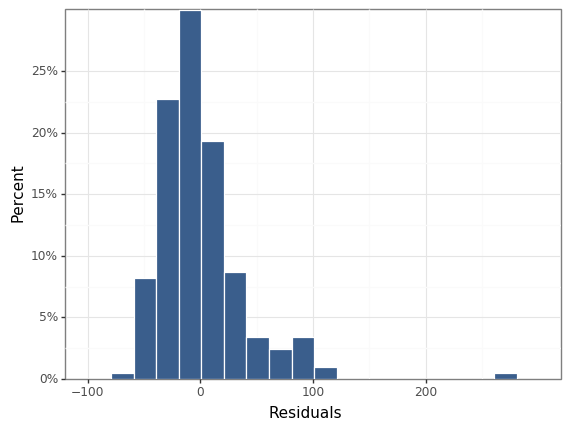

<ggplot: (8787287159083)>


In [42]:
# histogram of residuals
F07_6a = ggplot(hotels, aes(x="e")) + geom_histogram(
    aes(y="(..count..)/sum(..count..)"),
    binwidth=20,
    boundary=1,
    fill=color[0],
    color="white",
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + labs(x="Residuals", y="Percent") + scale_x_continuous(
    limits=(-100, 300), breaks=seq(-100, 300, by=100)
) + scale_y_continuous(
    expand=(0, 0), limits=(0, 0.3), breaks=seq(0, 0.3, by=0.05), labels=percent_format()
) + theme_bw()
print(F07_6a)

In [43]:
hotels["reg1_res"] = ["overpriced" if e >= 0 else "underpriced" for e in hotels["e"]]

In [44]:
hotels.loc[hotels["e"].sort_values().tail().index, "reg1_res"] = "top5"
hotels.loc[hotels["e"].sort_values().head().index, "reg1_res"] = "bottom5"

In [45]:
bestdeals = hotels.loc[hotels["e"].sort_values().head().index]

In [46]:
# FIXME
# print ch07-table-1-resid

##############
### Figure 7.7
### adding annotation

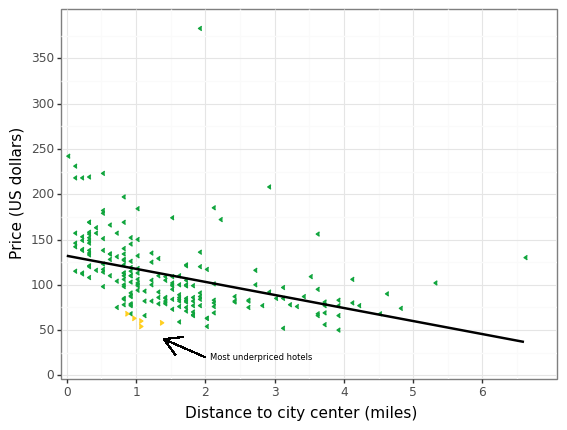

<ggplot: (8787287125309)>

In [47]:
ggplot(hotels, aes(x="distance", y="price")) + geom_point(
    hotels.loc[hotels["reg1_res"] == "overpriced"],
    aes(color="reg1_res"),
    size=1.3,
    shape=4,
    alpha=0.6,
    show_legend=False,
) + geom_point(
    hotels.loc[hotels["reg1_res"] == "underpriced"],
    aes(color="reg1_res"),
    size=1.3,
    shape=4,
    alpha=0.6,
    show_legend=False,
) + geom_point(
    hotels.loc[hotels["reg1_res"] == "bottom5"],
    aes(color="reg1_res", fill="reg1_res"),
    size=1.5,
    shape=5,
    alpha=0.8,
    show_legend=False,
) + geom_point(
    hotels.loc[hotels["reg1_res"] == "top5"],
    aes(color="reg1_res"),
    size=1.3,
    shape=4,
    alpha=0.6,
    show_legend=False,
) + geom_smooth(
    method="lm", size=1, se=False
) + coord_cartesian(
    xlim=(0, 7), ylim=(0, 400)
) + expand_limits(
    x=0.01, y=0.01
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 7), breaks=seq(0, 7, by=1)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 400, by=50)
) + labs(
    x="Distance to city center (miles)", y="Price (US dollars)"
) + scale_color_manual(
    name="", values=(color[1], color[1], color[1], color[1])
) + scale_fill_manual(
    name="", values=color[3]
) + annotate(
    "text", x=2.8, y=20, label="Most underpriced hotels", size=6
) + geom_segment(
    aes(x=2, y=20, xend=1.4, yend=40), arrow=arrow()
) + theme_bw()